In [4]:
import os
import numpy as np
from collections import defaultdict
from pyannote.core import Timeline, Annotation, Segment, notebook
from pyannote.database.util import load_rttm
from pyannote.metrics.diarization import DiarizationErrorRate, JaccardErrorRate
import matplotlib.pyplot as plt
%matplotlib inline

base_dir = '/home/jovyan/work'

# sequences of segment-level embeddings
voxcon_test_seqs = np.load(f'{base_dir}/sequences/fixed-voxcon-test-sequences.npy', allow_pickle=True).tolist()
# voxsrc21_seqs = np.load(f'{base_dir}/sequences/voxsrc21-sequences.npy', allow_pickle=True).tolist()

# segments intervals, for creating resulting RTTM and calculating DER and JER
voxcon_test_intervals = np.load(f'{base_dir}/sequences/fixed-voxcon-test-intervals.npy', allow_pickle=True).tolist()
# voxsrc21_intervals = np.load(f'{base_dir}/sequences/voxsrc21-intervals.npy', allow_pickle=True).tolist()

# reference labels for segments
voxcon_test_segment_labels = np.load(f'{base_dir}/sequences/voxcon-test-cluster-ids.npy', allow_pickle=True).tolist()

# ids sorted by processing order (regarding to seqs and interval clusters)
voxcon_test_audio_ids = ["aepyx","aiqwk","bjruf","bmsyn","bxcfq","byapz","clfcg","cqfmj","crylr","cvofp","dgvwu","dohag","dxbbt","dzsef","eauve","eazeq","eguui","epygx","eqsta","euqef","fijfi","fpfvy","fqrnu","fxnwf","fyqoe","gcfwp","gtjow","gtnjb","gukoa","guvqf","gylzn","gyomp","hcyak","heolf","hhepf","ibrnm","ifwki","iiprr","ikhje","jdrwl","jjkrt","jjvkx","jrfaz","jsbdo","jttar","jxpom","jzkzt","kajfh","kmunk","kpjud","ktvto","kvkje","lbfnx","ledhe","lilfy","ljpes","lkikz","lpola","lscfc","ltgmz","lubpm","luobn","mjmgr","msbyq","mupzb","myjoe","nlvdr","nprxc","ocfop","ofbxh","olzkb","ooxlj","oqwpd","otmpf","ouvtt","poucc","ppexo","pwnsw","qadia","qeejz","qlrry","qwepo","rarij","rmvsh","rxulz","sebyw","sexgc","sfdvy","svxzm","tkybe","tpslg","uedkc","uqxlg","usqam","vncid","vylyk","vzuru","wdvva","wemos","wprog","wwzsk","xggbk","xkgos","xlyov","xmyyy","xqxkt","xtdcl","xtzoq","xvxwv","ybhwz","ylzez","ytmef","yukhy","yzvon","zedtj","zfzlc","zowse","zqidv","zztbo","ralnu","uicid","laoyl","jxydp","pzxit","upshw","gfneh","kzmyi","nkqzr","kgjaa","dkabn","eucfa","erslt","mclsr","fzwtp","dzxut","pkwrt","gmmwm","leneg","sxqvt","pgtkk","fuzfh","vtzqw","rsypp","qxana","optsn","dxokr","ptses","isxwc","gzhwb","mhwyr","duvox","ezxso","jgiyq","rpkso","kmjvh","wcxfk","gcvrb","eddje","pccww","vuewy","tvtoe","oubab","jwggf","aggyz","bidnq","neiye","mkhie","iowob","jbowg","gwloo","uevxo","nitgx","eoyaz","qoarn","mxdpo","auzru","diysk","cwbvu","jeymh","iacod","cawnd","vgaez","bgvvt","tiido","aorju","qajyo","ryken","iabca","tkhgs","tbjqx","mqtep","fowhl","fvhrk","nqcpi","mbzht","uhfrw","utial","cpebh","tnjoh","jsymf","vgevv","mxduo","gkiki","bvyvm","hqhrb","isrps","nqyqm","dlast","pxqme","bpzsc","vdlvr","lhuly","crorm","bvqnu","tpnyf","thnuq","swbnm","cadba","sbrmv","wibky","wlfsf","wwvcs","xffsa","xkmqx","xlsme","ygrip","ylgug","ytula","zehzu","zsgto","zzsba","zzyyo"]
voxsrc21_audio_ids = ["tpine", "huqpy", "uzsvq", "pirso", "npnyp", "jsatj", "kuunx", "klbrr", "ecugo", "dwtow", "lhbqr", "zfipy", "wsobx", "jxkah", "hjvtj", "dpbgj", "phcxl", "uddju", "hufrz", "fibgq", "ahrcr", "cnbhz", "ahpuj", "biypq", "taukp", "iwvbh", "zobzz", "chvgo", "zsngo", "ixbvn", "ruwbp", "dufvn", "hajxp", "ohjjf", "veada", "zfzwt", "aqlrr", "qvroz", "cqfbd", "hzttx", "jrxnz", "gcccl", "qgzvk", "ieaoq", "jwezt", "ovxrk", "oitjh", "xivtm", "rnmrp", "euhwq", "iflmj", "hffvn", "eoxkf", "ycycy", "fwjhb", "yhntc", "ersxa", "afhlm", "uhpjz", "saenk", "oszsp", "zkmgn", "cgjuc", "vofje", "ajjmr", "mkbjy", "cxrjf", "jbirg", "hmnyo", "mknge", "xahab", "svnoe", "iucho", "uwgqx", "sfjjj", "rymcy", "rycwr", "fdtlj", "ewkei", "pojyu", "vrgwd", "bfwgq", "goots", "mrbme", "nzoid", "cehwp", "uosun", "pzrcf", "kpecv", "pwutv", "ipszk", "ktmre", "bylqb", "mrgru", "osrss", "ftajg", "xairp", "whibh", "xmkio", "rvyug", "tealt", "ezptn", "kpihx", "ubthy", "njuto", "komgz", "ahcuo", "lcowh", "vuqbp", "wnoyw", "zliuj", "dvofo", "yhivq", "xvaqn", "ixcig", "zauxp", "nzonc", "rvrlo", "xesmw", "mylgb", "askiw", "nsibk", "quinj", "swpjb", "fsfdw", "kcoeu", "eeivl", "tuczd", "jjbsx", "ytvbn", "dwsdu","fseqv", "zjrun", "pqifp", "aqind", "enrur", "vtdos", "ymvrw", "welcq", "wazie", "ssbra", "kxzac", "tcwva", "epbjz", "hkfjg", "bwpth", "cnwba", "vghwm", "usxym", "yyldd", "govov", "ueoss", "ivmhq", "gsigu", "sotzc", "ebixn", "zhcic", "ckivy", "tldnh", "hiukp", "lvrse", "sdpur", "ubitk", "reljk", "hfzhn", "axabh", "bmldz", "ujdjd", "kgzrb", "msnqr", "syucd", "ognux", "ahorw", "ifafa", "bpbon", "yywxf", "qezbm", "sljce", "nttgg", "uupjc", "gukfd", "hexbr", "jnoor", "rfyhi", "pbocz", "eqalx", "tpfau", "aoehz", "hmkzx", "zdymj", "qxezs", "irswh", "zktli", "dkpkx", "cqhil", "kxjyn", "rjpos", "kqlln", "vqzkm", "jucfh", "wjwes", "mebni", "ubogn", "obsbu", "dsuiy", "fmtir", "alpmg", "sndtu", "tkxsz", "qnuxe", "ctjzs", "uelsx", "xwaec", "bzlts", "fftup", "fqpdh", "ffcio", "wofgd", "oiyjs", "avvvz", "tbedi", "zyjfv", "bgkus", "linoq", "ptctn", "fhjbj", "wmhps", "lceba", "msswz", "rxldb", "lqvix", "vwgph", "zsgyz", "anojt", "lwxbp", "slldp", "jpjcy", "xpewn", "bamsl", "qmsgw", "wayap", "eizev", "nbema", "sqtvn", "oewsu", "rjdar", "rjmds", "vwftp", "ckeyp", "fcghr", "jfkiy", "ogkch", "iadsf", "jrnnn", "vjkrd", "brxew", "uyykg", "xikii", "zskbo", "xmezt", "kygkd", "rpjuz", "bmria", "eumxr"]

sequences = voxcon_test_seqs
intervals = voxcon_test_intervals
sample_ids = voxcon_test_audio_ids
segment_lables = voxcon_test_segment_labels

# load rttm files for metrics calculating
rttm_path = f'{base_dir}/datasets/voxconverse/test/rttm'
rttm_files = defaultdict(list)
for sample_id in sample_ids:
    rttm_files[sample_id] = os.path.join(rttm_path, sample_id + '.rttm')
    
uisrnn_rttm_path = f'{base_dir}/rttm-results/voxcon-test-uisrnn-rttm/rttm'
uisrnn_rttm_files = defaultdict(list)
for sample_id in sample_ids:
    uisrnn_rttm_files[sample_id] = os.path.join(uisrnn_rttm_path, sample_id + '.rttm')
    
spectral_rttm_path = f'{base_dir}/rttm-results/voxcon-test-spectral-rttm/rttm'
spectral_rttm_files = defaultdict(list)
for sample_id in sample_ids:
    spectral_rttm_files[sample_id] = os.path.join(spectral_rttm_path, sample_id + '.rttm')

In [39]:
# dzsef 13 - fuzfh 140 - epygx 17

idx = 17
sample_id = sample_ids[idx]
data = sequences[idx]
segments = Timeline(segments=[Segment(interval[0], interval[1]) for interval in intervals[idx]])
# sample_id

In [40]:
reference = load_rttm(rttm_files[sample_id])[sample_id]
hypothesis_uisrnn = load_rttm(uisrnn_rttm_files[sample_id])['<NA>']
hypothesis_spectral = load_rttm(spectral_rttm_files[sample_id])[sample_id]

In [44]:
X, Y_ref, Y_uis, Y_spec = [], [], [], []

length = len(data)
for segment, embedding in zip(segments, data):
    # average speech turn embedding
    X.append(embedding)

    # keep track of speaker label (for later scatter plot)
    y_ref = reference.argmax(segment)
    y_uis = hypothesis_uisrnn.argmax(segment)
    y_spec = hypothesis_spectral.argmax(segment)
    
    Y_ref.append(y_ref) 
    Y_uis.append(y_uis)
    Y_spec.append(y_spec)
    
    clear_output(wait=True)
    display(f'{idx+1} {100*(idx+1)/length:g}%')

X = np.vstack(X)
# _, y_ref_true = np.unique(Y_ref, return_inverse=True)
_, y_uis_true = np.unique(Y_uis, return_inverse=True)
_, y_spec_true = np.unique(Y_spec, return_inverse=True)

tsne = TSNE(n_components=2, metric="cosine")
X_2d = tsne.fit_transform(X)

'18 0.682853%'

['spk00', 'spk00', 'spk00', 'spk00', 'spk00', 'spk00', 'spk00', 'spk00', 'spk00', 'spk00', 'spk00', 'spk00', 'spk00', 'spk00', 'spk01', 'spk01', 'spk01', 'spk00', 'spk00', 'spk00', 'spk00', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', 'spk02', None, 'spk02', 'spk02', 'sp

In [56]:
y_ref_true = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 9, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7]

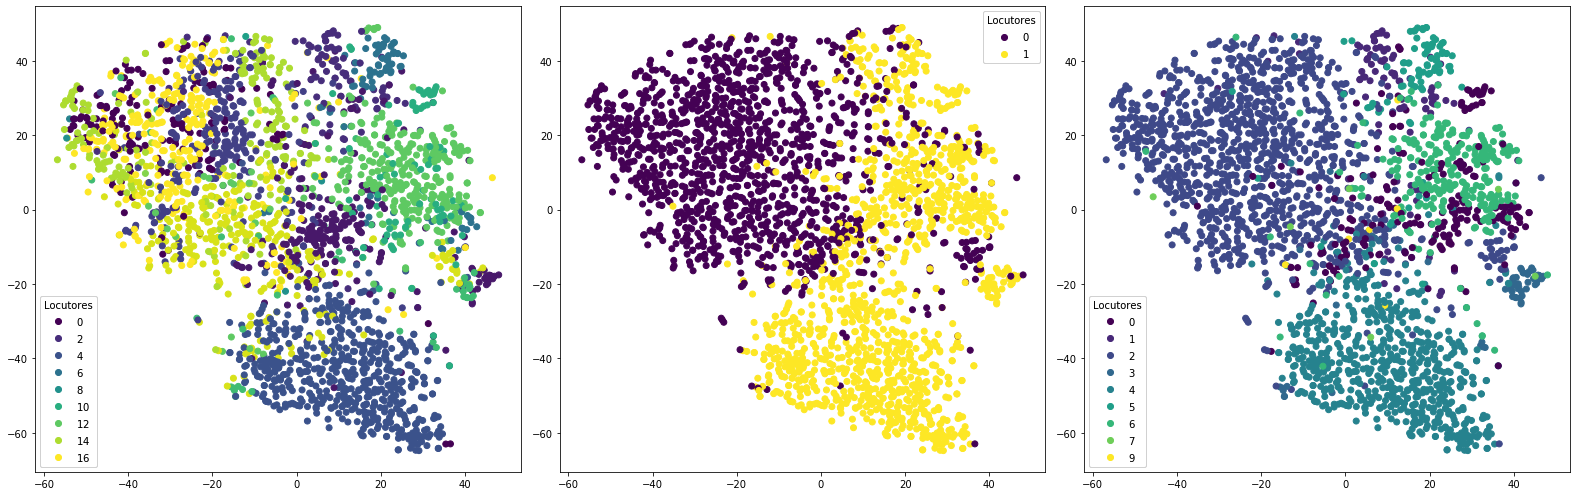

In [57]:
# plot 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.set_figheight(7,5)
fig.set_figwidth(22,5)
scatter0 = ax[0].scatter(*X_2d.T, c=y_uis_true)
scatter1 =ax[1].scatter(*X_2d.T, c=y_spec_true)
scatter2 =ax[2].scatter(*X_2d.T, c=y_ref_true)

legend0 = ax[0].legend(*scatter0.legend_elements(), title="Locutores")
ax[0].add_artist(legend0)
legend1 = ax[1].legend(*scatter1.legend_elements(), title="Locutores")
ax[1].add_artist(legend1)
legend2 = ax[2].legend(*scatter2.legend_elements(), title="Locutores")
ax[2].add_artist(legend2)

plt.tight_layout()
plt.show()